In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

In [ ]:
class MultiClassSVM(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultiClassSVM, self).__init__()
        self.linear = nn.Linear(input_size, num_classes,bias=False)

    def forward(self, x):
        return self.linear(x)
    
def hinge_loss(outputs, labels):
    num_classes = outputs.size(1)
    correct_indices = labels.view(-1, 1)
    correct_scores = outputs.gather(1, correct_indices)
    margins = torch.clamp(1 - (correct_scores - outputs), min=0)
    margins.scatter_(1, correct_indices, 0)
    loss = margins.mean()
    return loss

def train(
    model,
    train_loader,    
    ):
    for batch_idx, (data, target) in enumerate(train_loader):
        output = model(data.float())
        loss = hinge_loss(output, target)
        loss.backward()
        _, argmax = torch.max(output, 1)
        accuracy = (target == argmax.squeeze()).float().mean()
        print("accuracy is",accuracy)


In [ ]:
svm = MultiClassSVM(input_size=28,num_classes=10)

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=True,
        download=True,
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.PILToTensor(),
                
            ]
        ),
        
    ),
    batch_size=64,
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=False,
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.PILToTensor(),
                
            ]
        ),
    ),
    batch_size=64,
)
train(svm,train_loader)

In [5]:
import numpy as np
import os
data = np.load('D:/Asu/STAM/Norse/w1.npy')
print(data)
print("data shape",data.shape)

[[[[4.10702996e-05 9.36378837e-01 1.29742641e-03 3.69823337e-01
    1.31887514e-02]
   [2.30931607e-03 5.51534593e-01 3.56832403e-03 3.07461292e-01
    8.27993572e-01]
   [5.19678414e-01 9.94425178e-01 9.86868680e-01 7.22149134e-01
    2.95528412e-01]
   [6.18741475e-02 3.83269310e-01 9.81872439e-01 7.97549605e-01
    2.86403716e-01]
   [1.61923948e-04 3.39683378e-03 1.05721128e-05 2.95975823e-02
    9.07831669e-01]]]


 [[[9.99729991e-01 9.99992549e-01 9.99992549e-01 9.99992549e-01
    3.02034314e-03]
   [9.99992549e-01 9.99992549e-01 9.99992549e-01 9.99992549e-01
    4.17808860e-06]
   [9.99992549e-01 9.99992549e-01 9.99992549e-01 9.99928296e-01
    9.63756793e-06]
   [9.99952614e-01 9.99992549e-01 9.99992549e-01 7.24103011e-05
    1.46899755e-08]
   [9.99831796e-01 9.98916686e-01 9.99992549e-01 5.39566936e-05
    2.83375048e-08]]]


 [[[9.97395098e-01 4.45235419e-05 9.98806179e-01 9.65008616e-01
    9.64270294e-01]
   [4.45837975e-01 2.74303432e-07 9.78365004e-01 9.77798700e-01
    

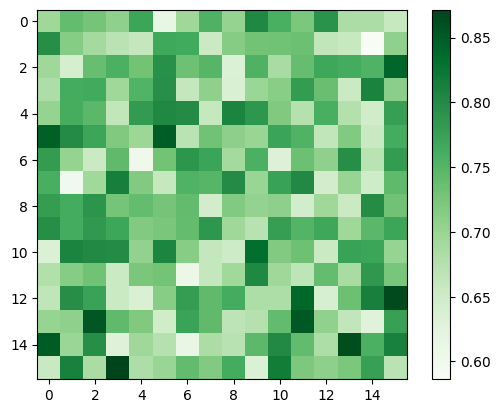

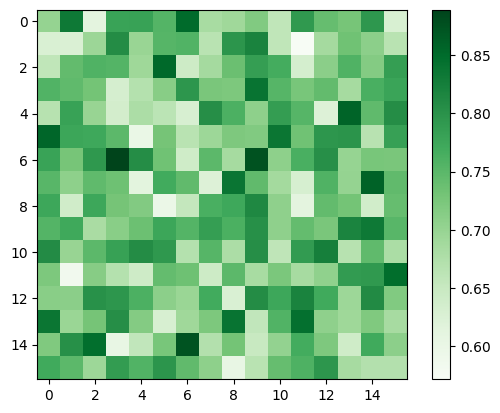

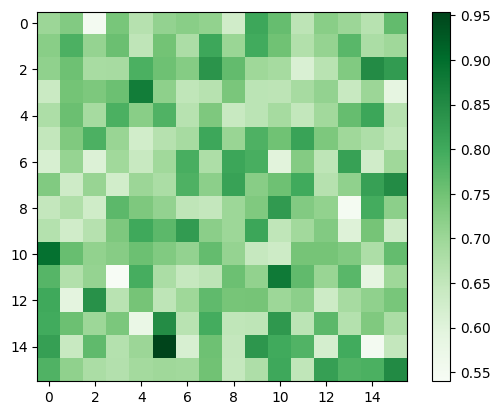

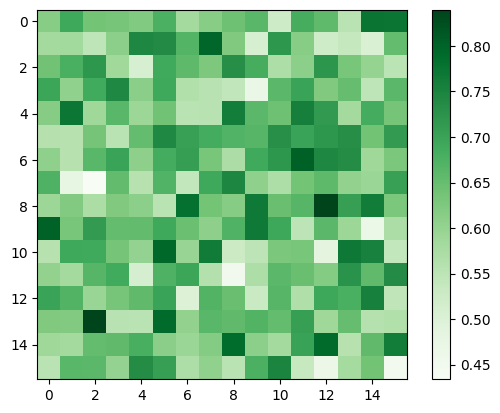

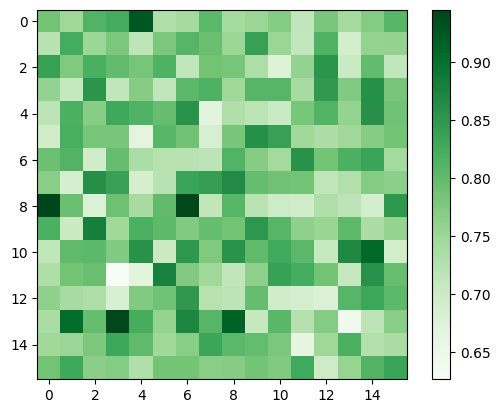

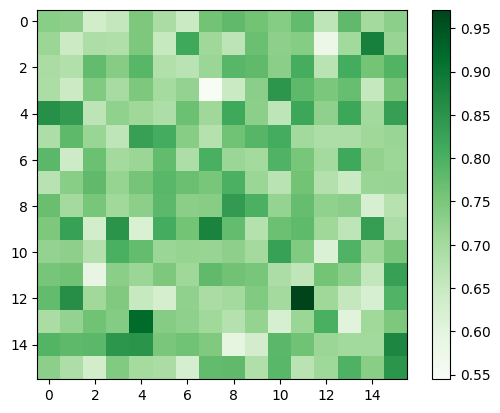

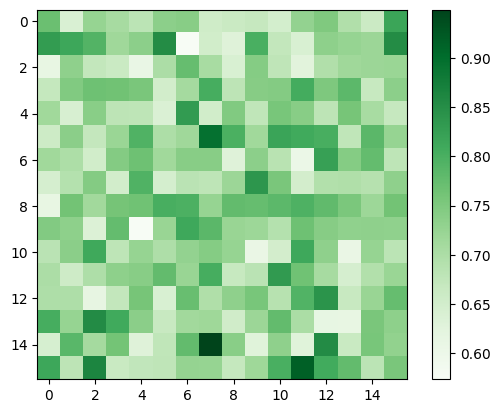

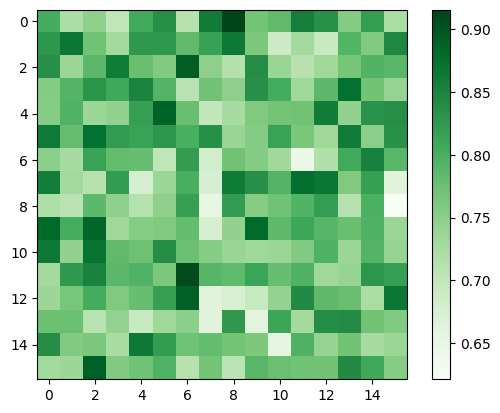

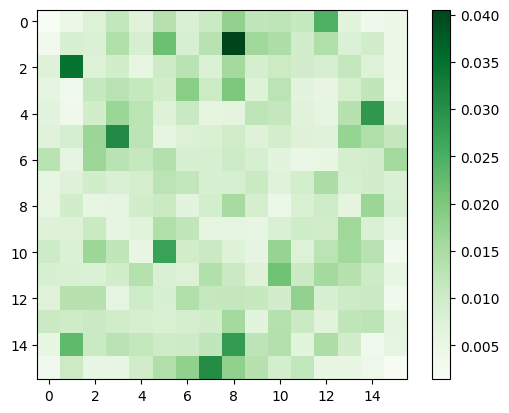

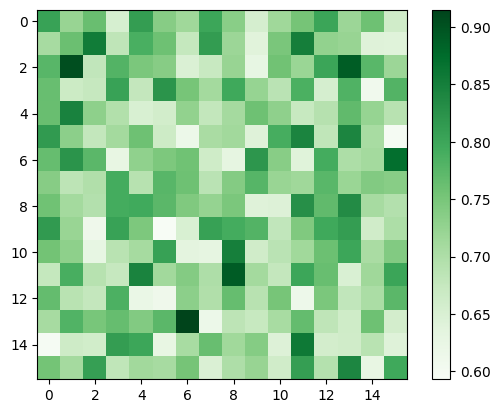

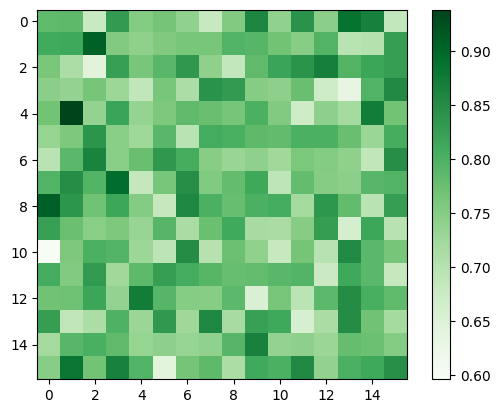

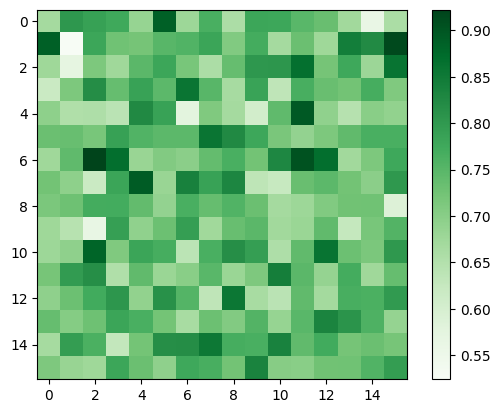

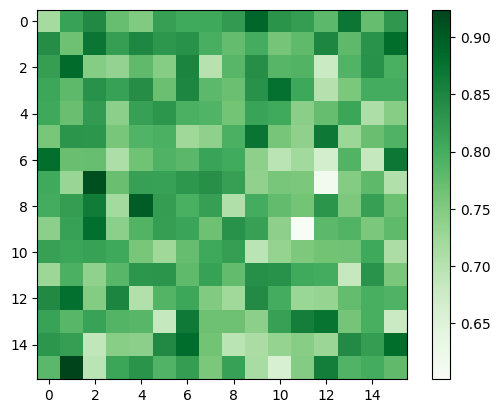

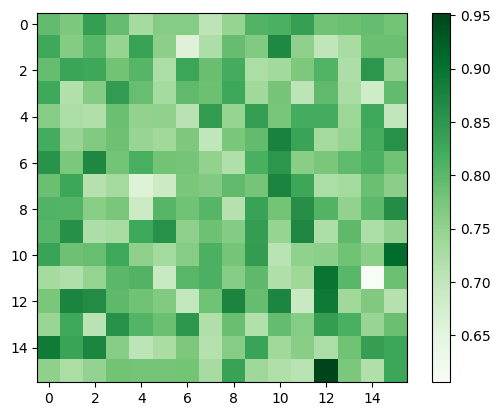

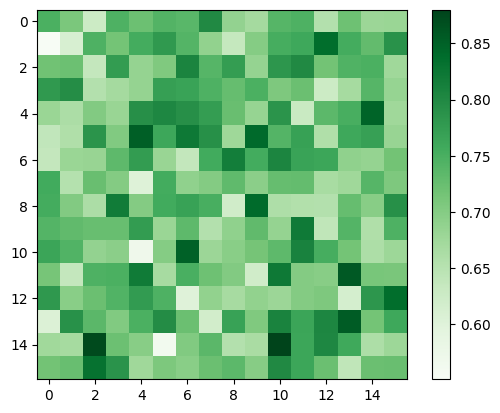

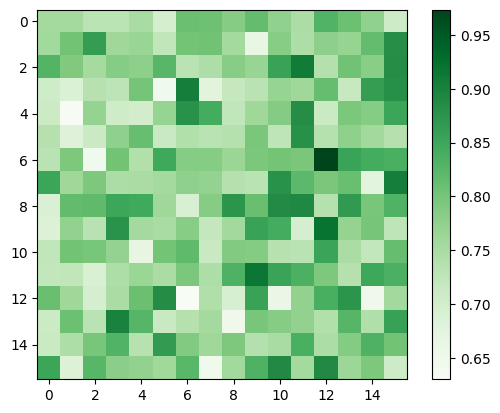

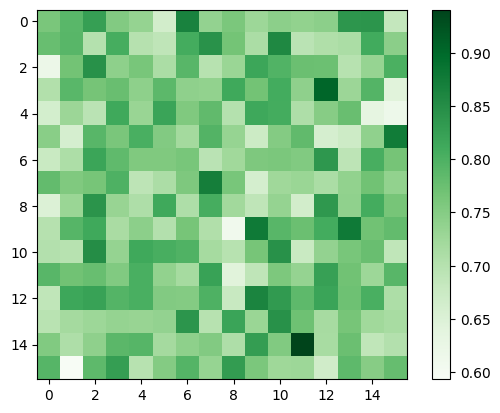

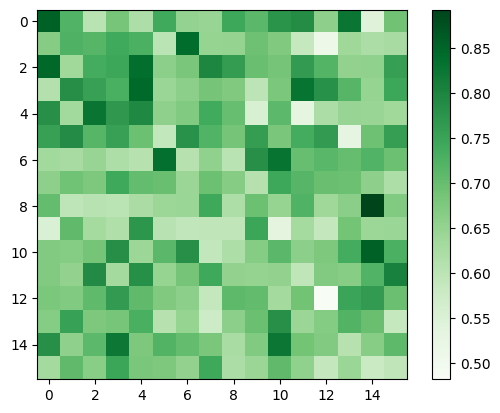

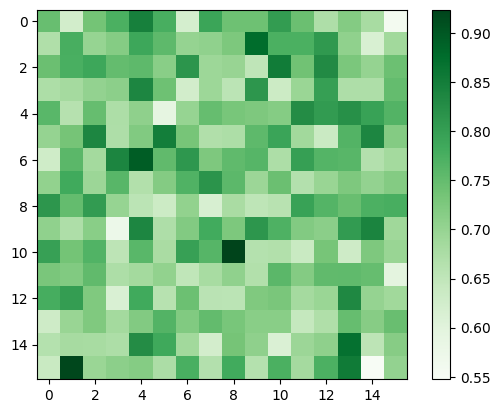

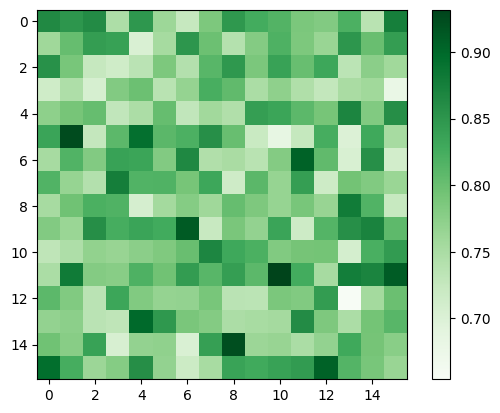

In [4]:
import numpy as np
import matplotlib.pyplot as plt
for i in range(data.shape[0]):
    plt.imshow(data[i,0], cmap='Greens', interpolation='nearest')
    plt.colorbar()  # 添加颜色条
    plt.show()
